In [34]:
from gee_tools import initialize_gee, XeeDataset  

In [35]:
initialize_gee('ee-ehsanjalilvand')


Successfully saved authorization token.
Successfully authenticated and initialized Earth Engine


In [36]:
# Example 1) irrigation mapping
# Create instance from GEE awsome data caltalog
dataset = XeeDataset('projects/sat-io/open-datasets/GFSAD/LGRIP30')
dataset.ee_bands()

,bands
0,b1


In [46]:
# instance inputs

# lon_min, lon_max = -125.0, -66.9  # Longitude range
# lat_min, lat_max = 24.4, 49.4     # Latitude range
# bbox = [lat_min, lat_max, lon_min, lon_max]
# var = 'b1'
# scale = 0.0003
var = 'b1'
scale = 30
# Chain operations
result = (dataset.
        #   ee_subset_time(['2020-01-01', '2020-12-31']).
          # ee_crop(bbox).
          ee_var_sel(var).
          to_xarray(scale=scale, crs=str(chip.rio.crs)))
          # xr_crop(bbox))
data = result.data
data.attrs
# .sel(x=slice(xmin, xmax), y=slice(ymin, ymax))

/opt/anaconda3/envs/geostream/lib/python3.12/site-packages/xee/ext.py:683: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


{'crs': 'EPSG:5070'}

In [94]:
np.arange(0.5, 13.5)

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5])

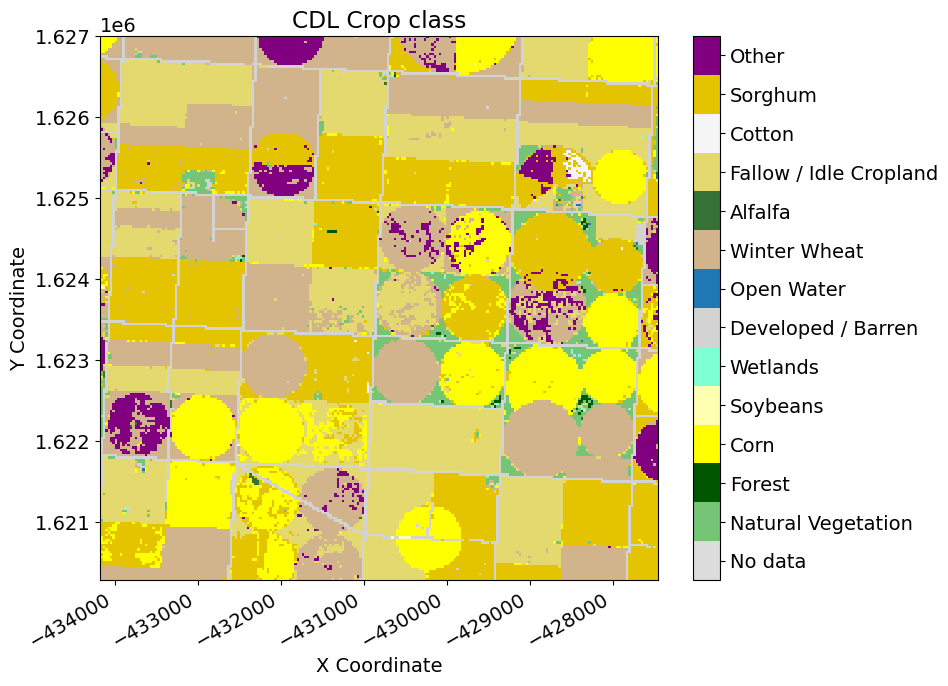

In [113]:
# reading crop classes chips
import os
import glob
import rioxarray as rio
import ee
import xarray as xr

file_id = 100

chip_dir= '/Users/ehsan/Documents/cropClass/datasets--ibm-nasa-geospatial--multi-temporal-crop-classification/snapshots/04b439f179e52a7b144f69676210eecd30c39cfc/training_chips'
files = glob.glob(os.path.join(chip_dir,'*mask.tif'))
# print(len(files))
original_chip = rio.open_rasterio(files[file_id])
chip_crs = str(original_chip.rio.crs)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
plt.rcParams.update({'font.size': 14})
colors = [
    '#dcdcdc',  # No Data - light grey
    '#76c476',  # Natural Vegetation - light green
    '#005700',  # Forest - dark green
    '#ffff00',  # Corn - yellow
    '#ffffb2',  # Soybeans - pale yellow
    '#7fffd4',  # Wetlands - aquamarine
    '#d3d3d3',  # Developed / Barren - grey
    '#1f77b4',  # Open Water - blue
    '#d2b48c',  # Winter Wheat - light brown
    '#347235',  # Alfalfa - rich green
    '#e4d96f',  # Fallow / Idle Cropland - tan
    '#f5f5f5',  # Cotton - light grey
    '#e4c400',  # Sorghum - deep yellow
    '#800080'   # Other - purple
]
cmap = plt.cm.colors.ListedColormap(colors)

# Create the plot
fig, ax = plt.subplots(figsize=(9, 8))

# Plot the data
im = original_chip.plot(
    x='x',
    cmap=cmap,
    add_colorbar=False,  # We'll add our own colorbar
    ax=ax,
    vmin =-0.5,
    vmax =13.5
)

# # Add a colorbar with custom labels
cbar = plt.colorbar(im, ax=ax, ticks=np.arange(0, 14))  # Center of each color band
cbar.ax.set_yticklabels(["No data",
    "Natural Vegetation", "Forest", "Corn", "Soybeans", "Wetlands",
    "Developed / Barren", "Open Water", "Winter Wheat", "Alfalfa",
    "Fallow / Idle Cropland", "Cotton", "Sorghum", "Other"
])
# Add title and labels
plt.title('CDL Crop class')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
fig.autofmt_xdate()
# original_chip.plot(x = 'x')


In [114]:
chip = original_chip.sel(band=1).drop('band')
chip

/var/folders/4j/085ft_gj57g6j3nstb4bppth0000gn/T/ipykernel_17667/110023159.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  chip = original_chip.sel(band=1).drop('band')


<xarray.DataArray (y: 224, x: 224)> Size: 50kB
[50176 values with dtype=uint8]
Coordinates:
  * x            (x) float64 2kB -4.342e+05 -4.341e+05 ... -4.275e+05 -4.275e+05
  * y            (y) float64 2kB 1.627e+06 1.627e+06 ... 1.62e+06 1.62e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

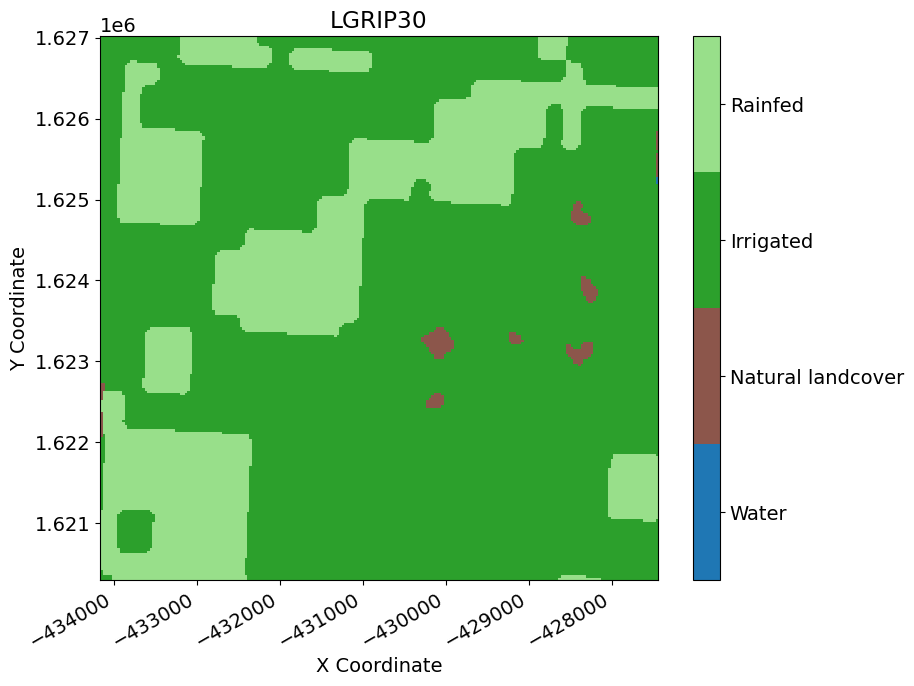

In [115]:
xmin, ymin, xmax, ymax = chip.rio.bounds() # (left, bottom, right, top) or (xmin, ymin, xmax, ymax)
bbox = [ymin,ymax,xmin,xmax]

ir_chip = data.sel(
            Y=slice(ymin, ymax),
            X=slice(xmin, xmax))
ir_chip = ir_chip.max(dim = 'time').rename({'X':'x','Y':'y'})
ir_chip = ir_chip.rio.write_crs(chip.rio.crs)
ir_chip = ir_chip.rio.write_transform(chip.rio.transform())
# ir_chip.b1.plot(x='x')
ir_chip = ir_chip.b1

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
plt.rcParams.update({'font.size': 14})
colors = ['#1f77b4','#8c564b', '#2ca02c', '#98df8a' ] 
cmap = plt.cm.colors.ListedColormap(colors)

# Create the plot
fig, ax = plt.subplots(figsize=(9, 8))

# Plot the data
im = ir_chip.plot(
    x='x',
    cmap=cmap,
    add_colorbar=False,  # We'll add our own colorbar
    ax=ax,
    vmin = 0,
    vmax =3
)

# # Add a colorbar with custom labels
cbar = plt.colorbar(im, ax=ax, ticks=[0.375, 1.125, 1.875, 2.625])  # Center of each color band
cbar.ax.set_yticklabels(['Water', 'Natural landcover','Irrigated', 'Rainfed' ])

# Add title and labels
plt.title('LGRIP30')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
fig.autofmt_xdate()


In [116]:
import rasterio
ir_chip_flipped = ir_chip.reindex(y=ir_chip.y[::-1])
ir_chip_flipped = ir_chip_flipped.transpose('y', 'x')

# 2. Now try the reproject_match
ir_chip_aligned = ir_chip_flipped.rio.reproject_match(
    chip,
    resampling=rasterio.enums.Resampling.nearest
)

In [117]:
# 1. Water mask (chip == 7)
water_mask = (chip == 7)

# 2. Cropland mask (values 3,4,8,9,11,12)
cropland_mask = chip.isin([3,4,8,9,11,12])

# 3. Create irrigated and rainfed masks
irrigated_mask = (ir_chip_aligned == 2)  
rainfed_mask = (ir_chip_aligned == 3)

# 4. Combine conditions
result = xr.where(water_mask, 0,  # Water as 0
        xr.where(cropland_mask & irrigated_mask, 1,  # Irrigated cropland as 1
        xr.where(cropland_mask & rainfed_mask, 2,  # Rainfed cropland as 2
                3)))  # Everything else as 3

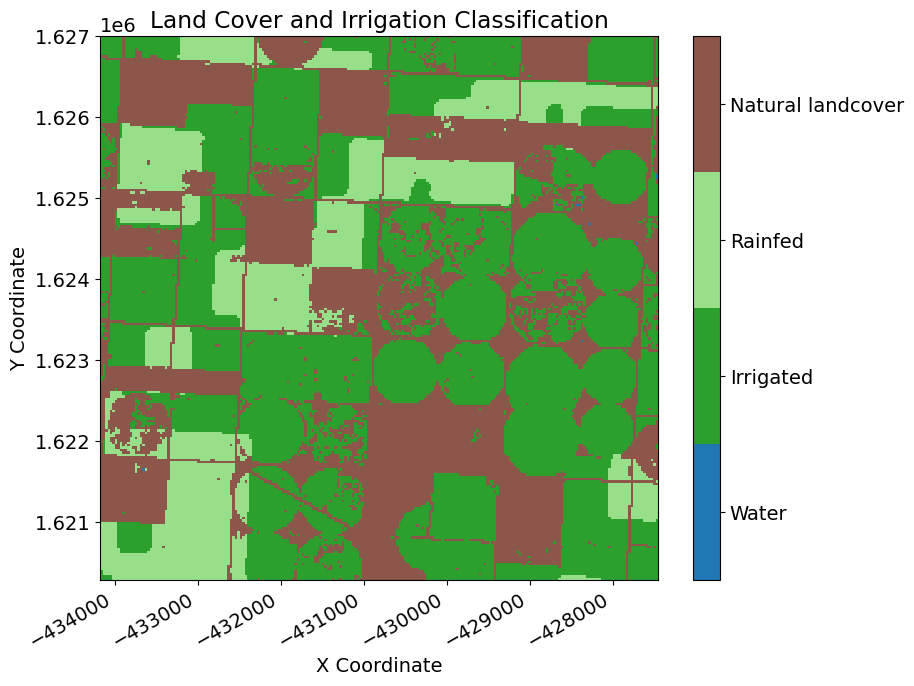

In [118]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
plt.rcParams.update({'font.size': 14})
colors = ['#1f77b4', '#2ca02c', '#98df8a', '#8c564b'] 
cmap = plt.cm.colors.ListedColormap(colors)

# Create the plot
fig, ax = plt.subplots(figsize=(9, 8))

# Plot the data
im = result.plot(
    x='x',
    cmap=cmap,
    add_colorbar=False,  # We'll add our own colorbar
    ax=ax,
    vmin =0,
    vmax =3
)

# # Add a colorbar with custom labels
cbar = plt.colorbar(im, ax=ax, ticks=[0.375, 1.125, 1.875, 2.625])  # Center of each color band
cbar.ax.set_yticklabels(['Water', 'Irrigated', 'Rainfed', 'Natural landcover'])

# Add title and labels
plt.title('Land Cover and Irrigation Classification')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
fig.autofmt_xdate()

In [83]:
# saving the geotiff file
from path import Path as p
output_path = str( f'/Users/ehsan/Documents/ir_training_chips' / p(files[10]).name)
output_path

# Add back the band dimension to match original chip format
result = result.expand_dims(dim={'band': [1]})  # Add band dimension back


# Copy all properties from original chip
result = result.rio.write_crs(original_chip.rio.crs)
result = result.rio.write_transform(original_chip.rio.transform())


# Copy other relevant attributes
result.attrs = original_chip.attrs
result.band.attrs = original_chip.band.attrs  # Copy band attributes if any


# Write to file
result.rio.to_raster(
    output_path,
    driver='GTiff',
    dtype=original_chip.dtype,
    nodata=original_chip.rio.nodata
)